<a href="https://colab.research.google.com/github/shitote/dist-repo/blob/main/transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rranfer Learnig Scaling up (🍰👁 Food Vision)

In [1]:
!nvidia-smi

Tue Feb 20 12:14:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-20 12:14:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-20 12:14:28 (60.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Working with less data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2024-02-20 12:14:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   125MB/s    in 13s     

2024-02-20 12:14:46 (116 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [6]:
# image classes
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/edamame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 image

In [7]:
# Se up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train the model.
steps to take.
* Create a modelCheckpoint callback
* Create a data augmentation.
* Build a headlsess functional api model.
* compile the model.
* Feature extraxt


In [10]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [13]:
# Create data augmentation layer
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentaion = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="dara_augmentation")


In [15]:
# set up the base model.
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainabe top layers
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentaion(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='gloabal_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)



In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 157s 617ms/step - loss: 3.3827 - accuracy: 0.2671 - val_loss: 2.4607 - val_accuracy: 0.4770
Epoch 2/5
237/237 [==============================] - 99s 418ms/step - loss: 2.1963 - accuracy: 0.4937 - val_loss: 2.0470 - val_accuracy: 0.5148
Epoch 3/5
237/237 [==============================] - 94s 394ms/step - loss: 1.8278 - accuracy: 0.5625 - val_loss: 1.8428 - val_accuracy: 0.5426
Epoch 4/5
237/237 [==============================] - 81s 341ms/step - loss: 1.6052 - accuracy: 0.6114 - val_loss: 1.7627 - val_accuracy: 0.5540
Epoch 5/5
237/237 [==============================] - 71s 300ms/step - loss: 1.4489 - accuracy: 0.6459 - val_loss: 1.7169 - val_accuracy: 0.5591


In [23]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 54s 68ms/step - loss: 1.5747 - accuracy: 0.5885


[1.5747439861297607, 0.588475227355957]

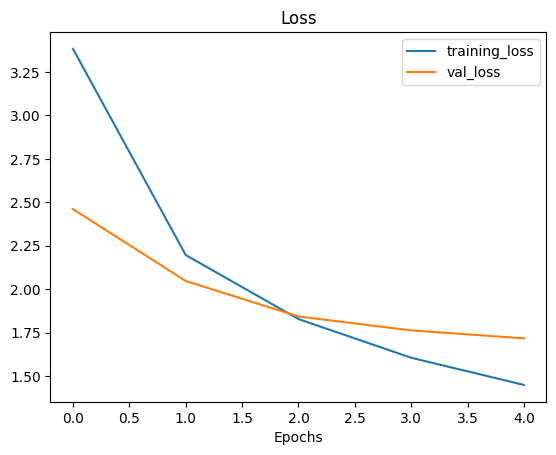

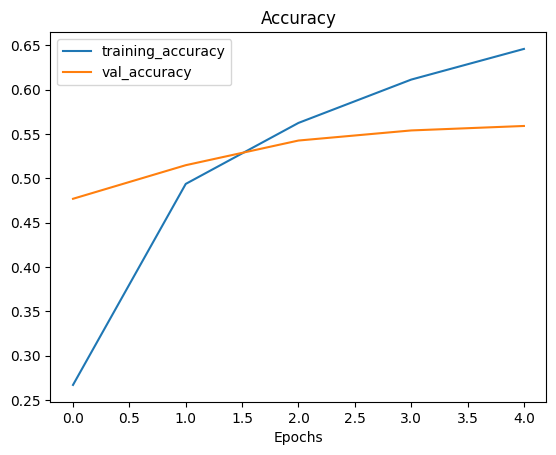

In [24]:
plot_loss_curves(history_all_classes_10_percent)

## FIne tuning

In [38]:
# Unfreeze all the layers in the base model to be trainable
base_model.trainable = True

# Refreeze every layer excep the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [40]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
dara_augmentation True
efficientnetb0 True
gloabal_avg_pool_layer True
output_layer True


In [41]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)


0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [42]:
# Fien tune for 5 more epoches
fine_tune_epochs = 10

# Fine-tune the model.
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 82s 311ms/step - loss: 1.2064 - accuracy: 0.6870 - val_loss: 1.6786 - val_accuracy: 0.5620
Epoch 6/10
237/237 [==============================] - 61s 256ms/step - loss: 1.0934 - accuracy: 0.7077 - val_loss: 1.6681 - val_accuracy: 0.5617
Epoch 7/10
237/237 [==============================] - 62s 258ms/step - loss: 1.0037 - accuracy: 0.7335 - val_loss: 1.6940 - val_accuracy: 0.5588
Epoch 8/10
237/237 [==============================] - 56s 236ms/step - loss: 0.9615 - accuracy: 0.7427 - val_loss: 1.6774 - val_accuracy: 0.5599
Epoch 9/10
237/237 [==============================] - 57s 239ms/step - loss: 0.8831 - accuracy: 0.7670 - val_loss: 1.6815 - val_accuracy: 0.5612
Epoch 10/10
237/237 [==============================] - 55s 230ms/step - loss: 0.8373 - accuracy: 0.7766 - val_loss: 1.7065 - val_accuracy: 0.5546


In [44]:
history_all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.4942 - accuracy: 0.6036


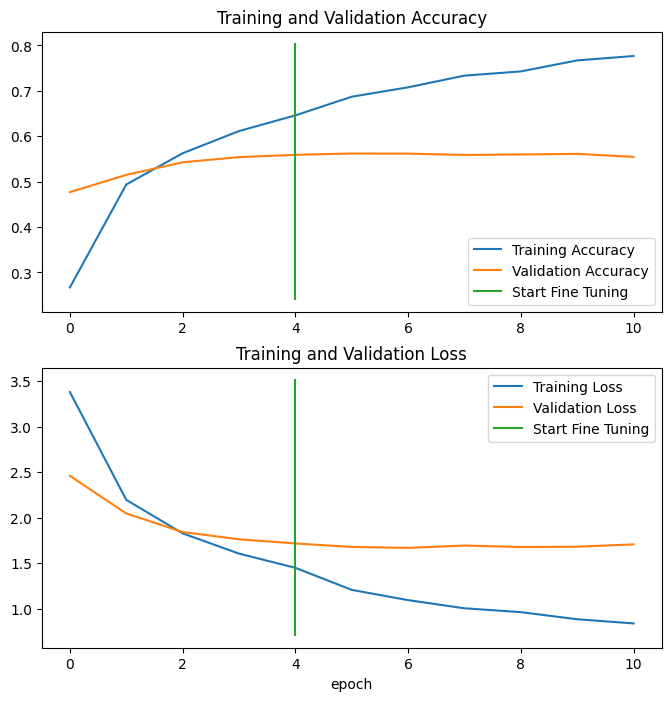

In [48]:
compare_historys(history_all_classes_10_percent,
    history_all_classes_10_percent_fine_tune)